# Банковская кластеризация (конкурс ДКЭ)

<b>Задача:</b> Необходимо обработать данные, создать целевой признак при помощи кластеризации и обучить модель для предсказания классов.

<b>Описание:</b> Банку "Все и сразу" необходимо знать, к какой группе относится определенный клиент. Для этого они хотят нанять Data Scientist'a, чтобы он реализовал их идею в жизнь. Всего банк смог собрать 30 признаков, которые, по их мнению, могут сыграть весомую роль в построении модели.

In [1]:
# обработка данных
import pandas as pd
import numpy as np

# подготовка данных
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# обучение модели
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# построение графиков
%matplotlib inline
%config InlineBckend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (16,7)

# дополнительные опции
pd.set_option('display.max_columns', None)

In [2]:
# загружаем данные
data = pd.read_csv('bank.csv')

---

## Анализ

In [3]:
# ознакомимся с признаками
data.head(5)

,Id,Income_base_type,Credit_purpose,Insurance_flag,DTI,Sex,Full_age_child_number,Education,Empl_type,Empl_size,Period_at_work,age,Empl_property,Empl_form,Family_status,Max_90_days,Avg_num_delay,If_zalog,Num_account_active_180,Active_to_all_prc,Num_account_active_all,Num_account_closed,Sum_of_paym_months,All_credits,Active_not_cc,Own_closed,Min_mnth_after_loan,Max_mnth_after_loan,Dlq_exist,Ninety_vintage
0,0,Форма банка (без печати работодателя),Ремонт,1.0,0.59,мужской,0,среднее-специальное,менеджер высшего звена,< 50,100.0,51.0,Транспорт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2НДФЛ,Ремонт,1.0,0.55,мужской,0,высшее,специалист,>250,29.0,52.0,Другое,Государственное предприятие,женат / замужем,1.0,0.022472,0.0,0.0,0.571429,4.0,3.0,87.0,7.0,3.0,0.0,7.0,74.0,1.0,0.0
2,2,2НДФЛ,Ремонт,1.0,0.23,женский,1,Высшее/Второе высшее/Ученая степень,менеджер среднего звена,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Свободная форма с печатью работодателя,Покупка земли,0.0,0.32,мужской,0,второе высшее,менеджер среднего звена,< 50,63.0,57.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Поступление зарплаты на счет,Ремонт,0.0,0.31,мужской,2,высшее,специалист,>250,106.0,34.0,Торговля,ОАО,женат / замужем,3.0,0.035971,0.0,0.0,0.666667,4.0,2.0,134.0,6.0,2.0,1.0,13.0,91.0,1.0,0.0


In [4]:
# проверка на наличие дубликатов
print(f'Дубликаты: {round(data.duplicated().sum() / (len(data) * len(data.columns)))}%')

# проверка на наличие пропусков
print(f'Пропуски: {round(data.isna().sum().sum() / (len(data) * len(data.columns)), 2)}%')

Дубликаты: 0%
Пропуски: 0.38%


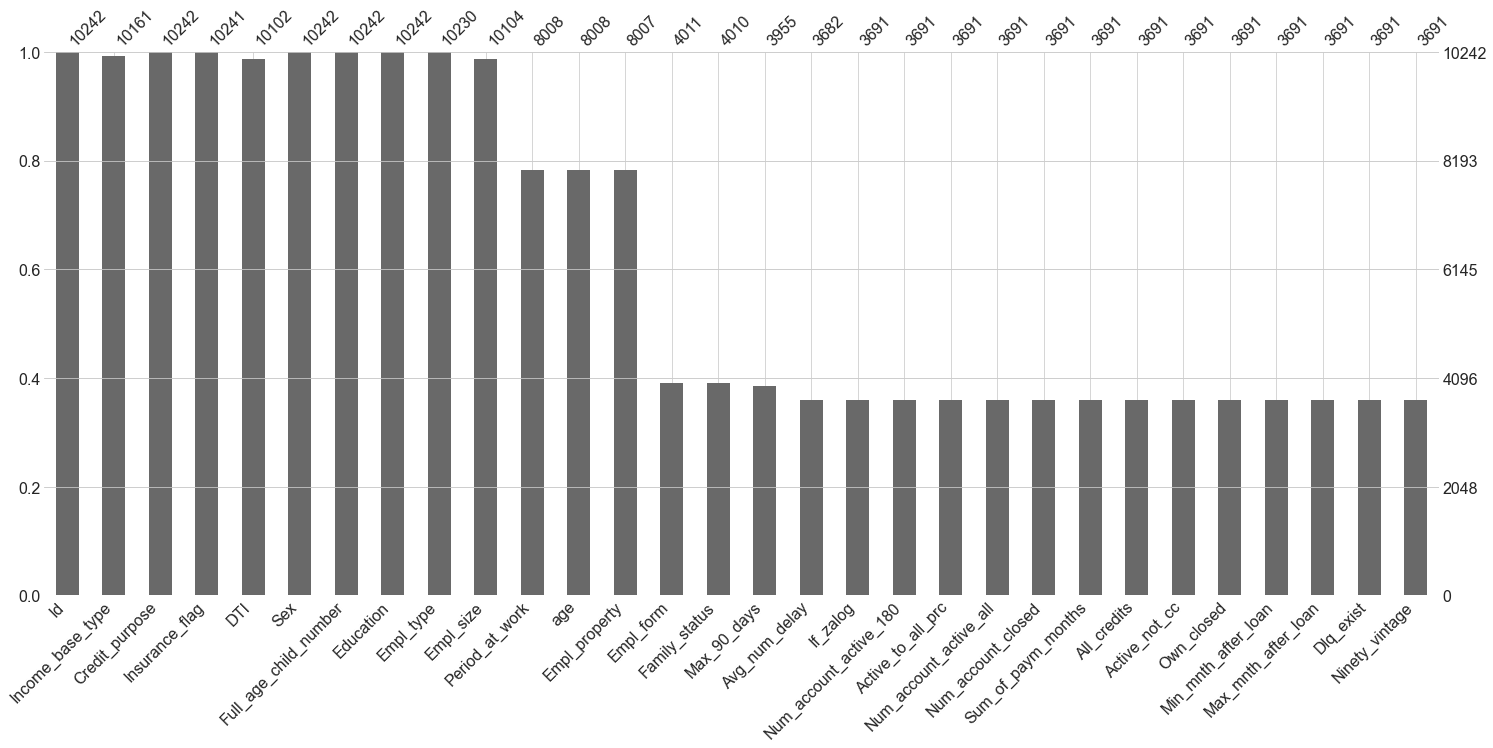

In [5]:
# процент заполненности от общего числа значений для кажого признака
msno.bar(data);

<b>Комментарий:</b> На графике можно наблюдать процент (слева) и абсолютное количество (справа и сверху) заполненных значений для каждого признака. Всего 10 признаков из 30 имеют пропуски < 2 процентов. Остальные же 20 признаков имею больший процент пропусков, что не позволяет нам удалить их невзирая на последствия. При этом bar-plot не дает нам информации о закономерности пропусков.

Построим специальную матрицу, которая позволит нам подтвердить теорию о закономерностях или отклонить ее:

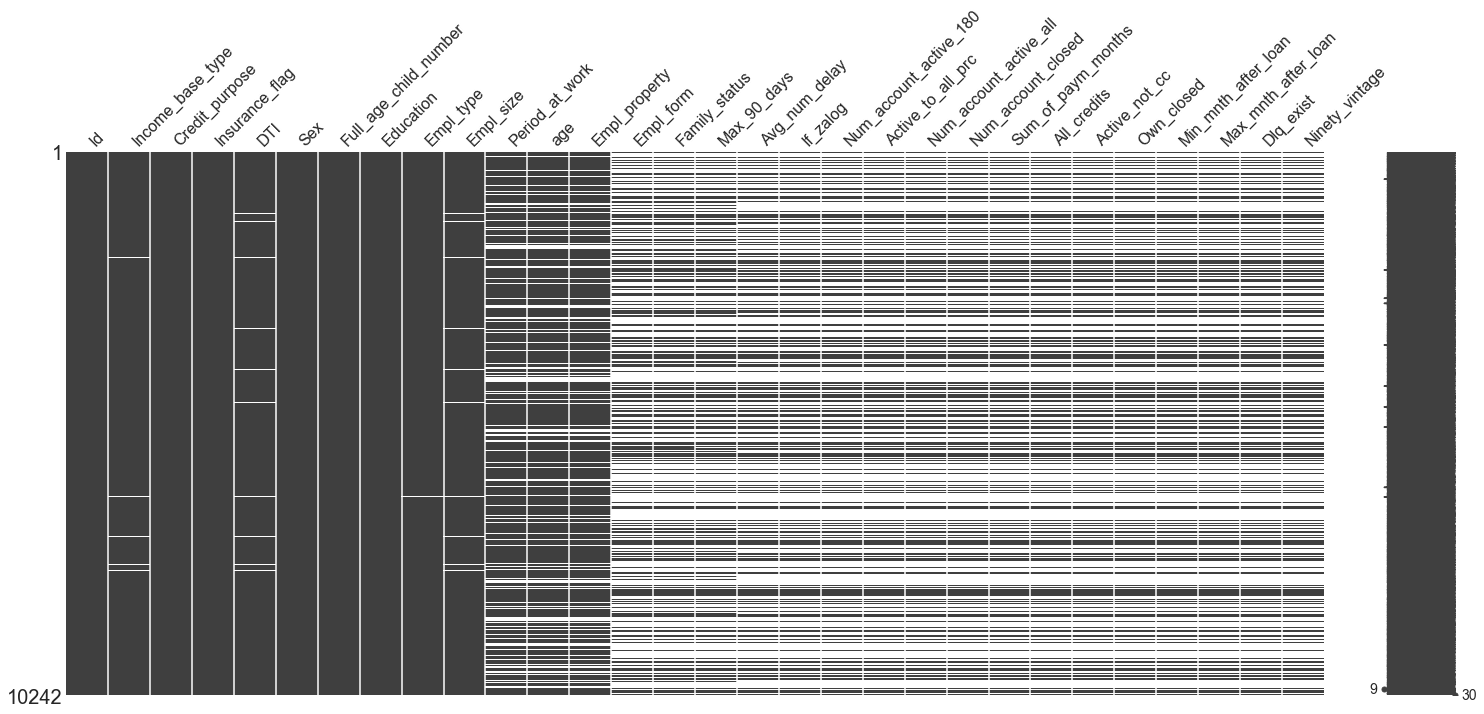

In [6]:
msno.matrix(data);

<b>Комментарий:</b> Нахождение закономерностей - задача творческая. На мой взгляд, в нашем случае закономерность пропусков видна невооруженным взглядом. Даже без корреляции видно, что пропуск в одном из признаков гарантирует пропуск и в других для той же самой строки.

Но для окончательного подтверждения теории и выбора пути решения проблемы, необходимо провести параметрический тест Корреляции Пирсона:

$$r_{pearson}=\frac{Cov_{x,y}}{s_x s_y}$$

Значения, приближающиеся к 1, указывают на сильную положительную линейную корреляцию. Близкие к −1 на сильную отрицательную линейную корреляцию. Значения около 0 означают отсутствие линейной корреляции. Важно отметить, что изменение масштаба данных не отразится на коэффициенте корреляции.

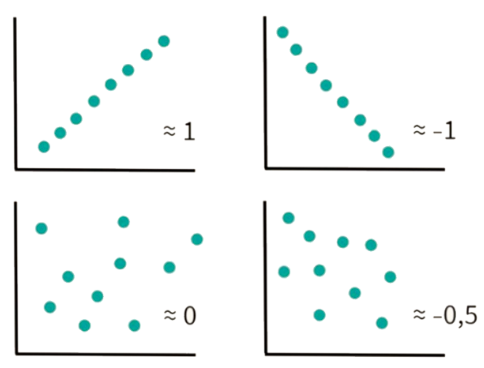

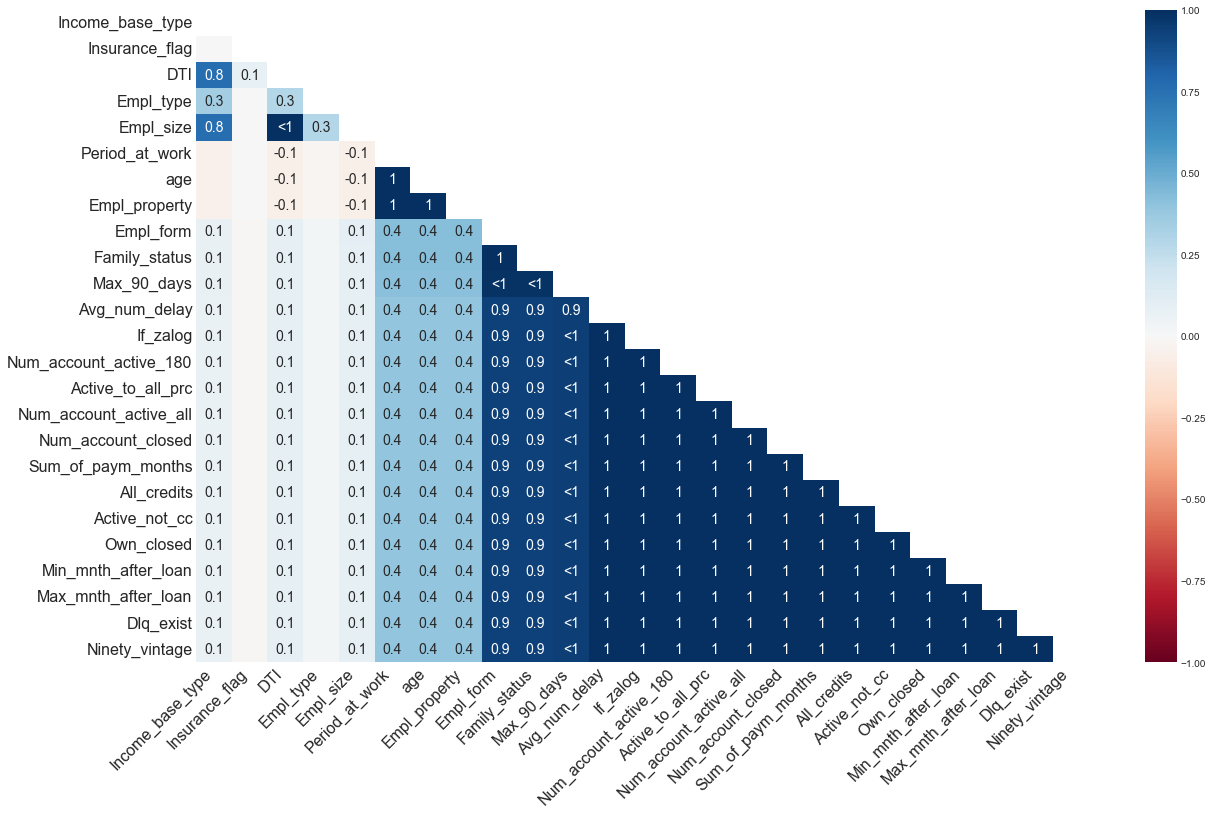

In [7]:
msno.heatmap(data);

<b>Комментарий:</b> Данная карта корреляции подтверждает теорию о закономерности большинства пропусков, позволяя нам и далее придерживаться концепции парных пропусков. Для подобных ситуаций, когда удаление 38% данных недопустимо, а заполнение средними значениями привело бы к итоговому отличию данных от нормального распределения, используется метод k-ближайших соседей.

---

## Обработка

In [8]:
# создадим копию датафрейма
features = data.drop('Id', axis=1).copy()

# функция поиска категориальных и числовых признаков
def cat_num_features(data):
    
    # найдем все категориальные признаки
    cat_columns = list(set(data).difference(set(data.describe().columns)))

    # найдем все числовые признаки
    num_columns = list(set(data).difference(set(cat_columns)))
    
    return cat_columns, num_columns


# разделим признаки на категориальные и числовые
cat_columns, num_columns = cat_num_features(features)

<b>Комментарий:</b> Удалим признак 'Id', который дублирует уникальный ключ данных, а затем найдем все категориальные и числовые признаки.

In [9]:
# OHE кодирование
features = pd.get_dummies(features, drop_first=True, dummy_na=True)

# минимаксное шкалирование
scaler = MinMaxScaler(feature_range=(0, 1))
features[num_columns] = scaler.fit_transform(features[num_columns])

<b>Комментарий:</b> Проведем OHE кодирование с параметром drop_first=True, чтобы избежать дамми-ловушки и закодировать категориальные данные в одно активное состояние, а также добавим параметр dummy_na=True, благодаря которому функция сможет добавлять новые состояния для признаков, имеющих пропуски. Числовые же данные необходимо прошкалировать, чтобы равномерно распределить их от 0 до 1:

$$x_i' = \frac{x_i - x_{min}}{x_{max}-x_{min}}$$

In [10]:
# метод ближайших соседей
imputer = KNNImputer(n_neighbors=3, weights='uniform')

# заполним пропуски
features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

features.head(5)

,Insurance_flag,DTI,Full_age_child_number,Period_at_work,age,Max_90_days,Avg_num_delay,If_zalog,Num_account_active_180,Active_to_all_prc,Num_account_active_all,Num_account_closed,Sum_of_paym_months,All_credits,Active_not_cc,Own_closed,Min_mnth_after_loan,Max_mnth_after_loan,Dlq_exist,Ninety_vintage,Income_base_type_3НДФЛ,Income_base_type_Поступление зарплаты на счет,Income_base_type_Свободная форма с печатью работодателя,Income_base_type_Форма банка (без печати работодателя),Income_base_type_nan,Credit_purpose_Лечение,Credit_purpose_Обучение,Credit_purpose_Отпуск,Credit_purpose_Покупка автомобиля,Credit_purpose_Покупка бытовой техники,Credit_purpose_Покупка земли,Credit_purpose_Покупка мебели,Credit_purpose_Покупка недвижимости/ строительство,Credit_purpose_Ремонт,Credit_purpose_nan,Sex_мужской,Sex_nan,Education_Высшее/Второе высшее/Ученая степень,Education_Неполное среднее,Education_второе высшее,Education_высшее,Education_незаконченное высшее,Education_среднее,Education_среднее-специальное,Education_ученая степень,Education_nan,Empl_type_другое,Empl_type_менеджер высшего звена,Empl_type_менеджер по продажам,Empl_type_менеджер среднего звена,Empl_type_рабочий,Empl_type_специалист,Empl_type_страховой агент,Empl_type_торговый представитель,Empl_type_nan,Empl_size_< 50,Empl_size_>100,Empl_size_>250,Empl_size_>=100,Empl_size_>=150,Empl_size_>=200,Empl_size_>=50,Empl_size_nan,Empl_property_Другое,Empl_property_Информационные технологии,Empl_property_Наука,Empl_property_Производство,Empl_property_Сельское и лесное хозяйство,Empl_property_Строительство,Empl_property_Торговля,Empl_property_Транспорт,Empl_property_Туризм,Empl_property_Финансы,Empl_property_Юридические услуги,Empl_property_nan,Empl_form_ЗАО,Empl_form_Иная форма,Empl_form_Индивидуальный предприниматель,Empl_form_ОАО,Empl_form_ООО,Empl_form_nan,Family_status_гражданский брак,Family_status_женат / замужем,Family_status_повторный брак,Family_status_разведен / разведена,Family_status_холост / не замужем,Family_status_nan
0,1.0,1.000000,0.0,0.078595,0.700000,0.066667,0.004704,1.0,0.333333,0.361111,0.190476,0.135802,0.269704,0.177778,0.259259,0.166667,0.279279,0.419476,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.929825,0.0,0.019231,0.725000,0.050000,0.023624,0.0,0.000000,0.571429,0.285714,0.111111,0.188720,0.200000,0.333333,0.000000,0.072072,0.421348,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.368421,0.2,0.086120,0.341667,0.083333,0.043203,0.0,0.066667,0.472222,0.119048,0.098765,0.140275,0.111111,0.148148,0.125000,0.111111,0.410112,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.526316,0.0,0.047659,0.850000,0.033333,0.008985,1.0,0.000000,0.200000,0.095238,0.049383,0.071584,0.055556,0.111111,0.083333,0.291291,0.338951,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.508772,0.4,0.083612,0.275000,0.150000,0.037816,0.0,0.000000,0.666667,0.285714,0.074074,0.290672,0.166667,0.222222,0.125000,0.126126,0.516854,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [11]:
print(f'Итоговое количество пропусокв: {features.isna().sum().sum()}')

Итоговое количество пропусокв: 0


<b>Комментарий:</b> Метод ближайших соседей прост и в то же время эффективен (хотя он и относится к алгоритмам с высокой временной сложностью). Алгоритм k-ближайших соседей потребует двух циклов:

- В первом цикле мы будем поочередно брать по одному вектору запроса
- Во втором вложенном в него цикле мы будем для каждого вектора запроса находить расстояние до всех векторов сравнения.
- Наконец, найдя и отсортировав вектора сравнения по расстоянию, выберем для каждого вектора запроса k-ближайших.

В итоге, после обработки, ни категориальные, ни числовые признаки не имеют пропусков, что позволит нам корректно разделить данные на классы.

---

## Кластеризация

Для кластеризации мы применим KMeans. Цель алгоритма - минимизировать сумму квадратов внутрикластерных расстояний до центра кластера (WCSS):

$$J=\sum^{k}_{j=1} \sum^{n}_{i=1} min(||x^{(j)}_{i} - c_{j}||)^2$$

Но сколько кластеров необходимо для наших данных? Поскольку знания предметной области нам не помогут в данной задачи, выявлять необходимое количество мы будем экспериментально.

In [12]:
# ошибка wcss
wcss = []

# количество кластеров от 1 до 15
for i in range(1, 16):
    
    # создадим модель кластеризации
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=5000, n_init=50, random_state=21)
    kmeans.fit(features)
 
    # рассчитаем ошибку для каждого кластера
    wcss.append(kmeans.inertia_)

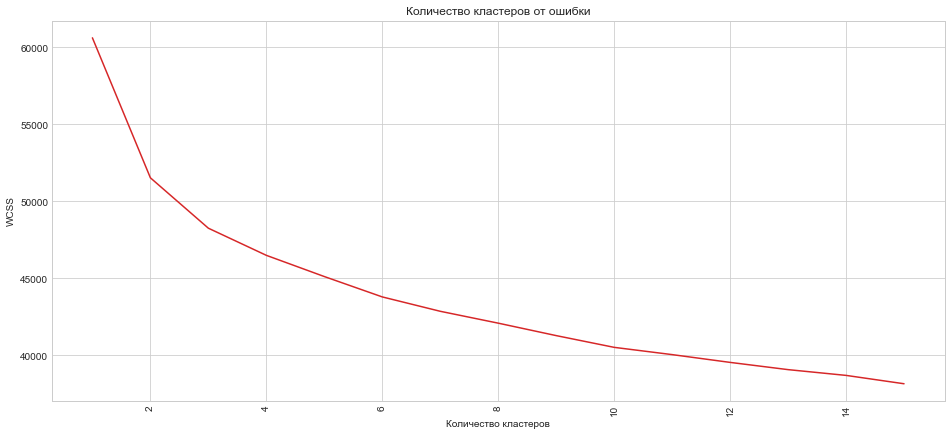

In [13]:
plt.plot(range(1, 16), wcss, color='tab:red')
plt.title('Количество кластеров от ошибки')
plt.ylabel('WCSS')
plt.xlabel('Количество кластеров')
plt.xticks(rotation = 90);

<b>Комментарий:</b> Исходя из графика нельзя сделать точный вывод, но есть два фактора, которые помогут сделать окончательный выбор.

- После 3 кластера, потери хоть и снижаются, но намного менее интенсивно
- Логическое понимание не позволяет утвердить количество кластеров свыше 6, поскольку банк разделил бы подобные группы максимум на 3-6 кластеров.

Исходя из этого, имеет смысл выбрать максимальным количеством - 3 кластера.

In [14]:
# создаем модель
model = KMeans(n_clusters=3, init='k-means++', max_iter=5000, n_init=50, random_state=21)

# делаем предсказания
target = model.fit_predict(features)

# добавляем единицу, чтобы избавиться от нулевой группы
target = target + 1

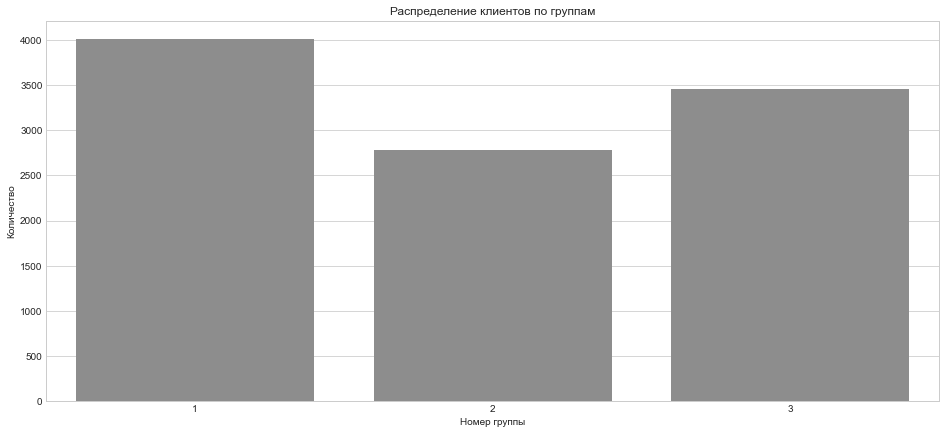

In [15]:
chart = pd.DataFrame(pd.DataFrame(target).value_counts().sort_index(), columns=['clasters']).reset_index()
sns.barplot(data=chart, x=0, y='clasters', color='#8d8d8d')
plt.title('Распределение клиентов по группам')
plt.ylabel('Количество')
plt.xlabel('Номер группы');

---

## Предсказание

In [16]:
# разделим данные на обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.6, random_state=21, shuffle=True)

# разделим данные на валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, train_size=0.5, random_state=21, shuffle=True)

<b>Комментарий:</b> Чтобы иметь возможность оценить качество предсказаний нашей модели, необходимо разделить данные на 3 части. Это делается для объективной оценки, поскольку тренировочные и валидационные данные будут задействованы в процессе обучения, а тестовые будут изолированы от модели и впервые она их увидит только на финальном этапе, который и выдаст нам итоговое качество.

In [17]:
# создадим модель
model = CatBoostClassifier(loss_function='MultiClass', random_state=21)

# зададим гиперпараметры
parametrs = {'n_estimators': [100, 150, 200, 250, 300],
             'max_depth': [3, 4, 5],
             'learning_rate': [0.1, 0.01]}

# найдем лучшие гиперпараметры из заданных
search = GridSearchCV(model, parametrs, cv=5, 
                      scoring='accuracy',
                      n_jobs=-1, verbose=True)

# обучим модель с использованием сетки поиска  GridSearch
search.fit(features_train, target_train,
           eval_set=(features_valid, target_valid),
           verbose=False, plot=False)

print(f'Лучший результат: {search.best_score_}')
print(f'Лучшие параметры: {search.best_params_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучший результат: 0.9982099267697315
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


<b>Комментарий:</b> Процесс поиска лучших гиперпараметров для градиентного бустинга зачастую банален. Нам просто необходимо помнить, что суть бустинга - имитация градиентного спуска за счёт высокого смещения и низкой дисперсии, которая получается при глубине дерева от 3-5. А также нельзя забывать, что n_estimators - играет весомую роль в моделях с шагом сходимости, так как если значение будет слишком большим, мы можем уйти из точки оптимума. Важно заметить, чем больше learning_rate, тем меньше должен быть n_estimators и наоборот.

---

<b>Комментарий:</b> Для итоговой оценки качества стоит выбрать метрику Accuracy, поскольку именно она является метрикой, которая характеризует качество модели, агрегированное по всем классам. Это полезно, когда классы для нас имеют одинаковое значение, как в нашем случае. Если это не так, accuracy может быть обманчивой.

$$accuracy = \frac{1}{n} \sum_{i=1}^n [y_i=f(x_i)]$$

In [18]:
# создадим модель
model = CatBoostClassifier(loss_function='MultiClass', learning_rate=0.1, max_depth= 4, n_estimators=200, random_state=21)

# обучим модель
model.fit(features_train, target_train,
          eval_set=(features_valid, target_valid),
          verbose=False, plot=True)

# предскажем результат
predictions = model.predict(features_test)

print(f'Итоговое качество Accuracy: {accuracy_score(predictions, target_test)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Итоговое качество Accuracy: 0.9980478282088824


<b>Комментарий:</b> Итоговое качество является весьма высоким, позволяя практически безошибочно отнести неизвестного клиента к одному из классов. Градиентный бустинг отлично справился с подобного рода задачей.

---

<b>Вывод:</b> Была проделана объемная работа, но банк "Все и сразу" получил свой заказ в лучшем виде. Как и было прописано в договоре, проект включает в себя кластеризацию, разделяющую пользователей на группы и классификацию, позволяющую определить, к какой группе относится тот или иной клиент. Поскольку кластеризация была необходима только для обучения модели, банку будет необходимо поддерживать мощности только для классификации, которая в итоговаом своем варианте выдает высокий показатель соответствия клиента к тому или иному классу. В перспективе, подобная методика увеличит доходы банка, снизив затраты на содержание лишних отделов с персоналом, которые работали с клиентами напрямую, пытаясь отнести их к одной из групп.